# Identifying Known Rink Locations
The objective of this program is to identify known rink locations and learn how to identify them on a sequence of images.

In [1]:
import os 
import sys
import tensorflow as tf                                                                                        
import numpy as np  
import pandas as pd
# import pickle                                                                   
# import matplotlib as mpl
# #mpl.use('Agg')
import matplotlib.pyplot as plt   
import matplotlib.image as mpimg
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
# #import matplotlib.axes as ax
# from sklearn.metrics import confusion_matrix    
# import itertools
# import scipy.misc
# import imageio
import json
import cv2
%load_ext autoreload

%aimport helper

#download inception for its transfer layer
import inception
inception.maybe_download()

SRC_PATH = os.path.abspath("./")

from time import time 


Data has apparently already been downloaded and unpacked.


In [2]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'   
JSON_DIR = os.path.abspath("./")
IMAGE_DIR = os.path.join(SRC_PATH, "./images")
stime = time()

### Load the json labels
The json file contains all labeled rink locations, and labels not in the images should be labeled as (-1,-1)

In [2]:
import sys
sys.path

['',
 '/Users/Austin_Egri/Documents/RPI/2017-2018_Senior_Year/Spring_Semester/Hockey_URP/Rink_Location_ID',
 '/Users/Austin_Egri/.virtualenvs/3tensorflow/lib/python3.6/site-packages/tensorflow/models',
 '/Users/Austin_Egri/Documents/RPI/2017-2018_Senior_Year/Spring_Semester/Hockey_URP/Rink_Location_ID/$/Users/Austin_Egri/.virtualenvs/caffe2',
 '/Users/Austin_Egri/Documents/RPI/2017-2018_Senior_Year/Spring_Semester/Hockey_URP/Rink_Location_ID/$/usr/local/bin',
 '/Users/Austin_Egri/.virtualenvs/3tensorflow/lib/python36.zip',
 '/Users/Austin_Egri/.virtualenvs/3tensorflow/lib/python3.6',
 '/Users/Austin_Egri/.virtualenvs/3tensorflow/lib/python3.6/lib-dynload',
 '/usr/local/Cellar/python/3.6.5_1/Frameworks/Python.framework/Versions/3.6/lib/python3.6',
 '/Users/Austin_Egri/.virtualenvs/3tensorflow/lib/python3.6/site-packages',
 '/Users/Austin_Egri/.virtualenvs/3tensorflow/lib/python3.6/site-packages/mask_rcnn-2.1-py3.6.egg',
 '/Users/Austin_Egri/.virtualenvs/3tensorflow/lib/python3.6/site-pa

### Declare list of labels to predict
Out of the possible known rink locations, these are the ones that appear in our dataset

In [3]:
known_rink_locs = ['Red Line', 
                    'Red Line Bottom',
                'Right Blue Line', 
                    'Right Blue Line Bottom', 
                    'Left Blue Line', 
                    'Left Blue Line Bottom',
                'Right Goal Line', 
                    'Right Goal Line Bottom', 
                    'Left Goal Line',
                    'Left Goal Line Bottom',
                'Center ice',
                'Right Top Neutral Faceoff Dot',
                    'Right Bottom Neutral Faceoff Dot',
                    'Left Top Neutral Faceoff Dot',
                    'Left Bottom Neutral Faceoff Dot',
                'Right Top Zone Faceoff Dot',
                    'Right Bottom Zone Faceoff Dot',
                    'Left Top Zone Faceoff Dot',
                    'Left Bottom Zone Faceoff Dot',
                'Right Top Goal Post',
                    'Right Bottom Goal Post',
                    'Left Top Goal Post',
                    'Left Bottom Goal Post',
                'Left Top Hash-Left Inner Hash Mark',
                    'Left Top Hash-Right Inner Hash Mark',
                    'Left Bottom Hash-Left Inner Hash Mark',
                    'Left Bottom Hash-Right Inner Hash Mark',
                    'Right Top Hash-Left Inner Hash Mark',
                    'Right Top Hash-Right Inner Hash Mark',
                    'Right Bottom Hash-Left Inner Hash Mark',
                    'Right Bottom Hash-Right Inner Hash Mark']
print(len(known_rink_locs))
known_rink_loc_set = set(known_rink_locs)

D = len(known_rink_locs)
key_loc_pairs = {'Red Line': 0, 
                    'Red Line Bottom':1,
                'Right Blue Line': 2, 
                    'Right Blue Line Bottom': 3, 
                    'Left Blue Line': 4, 
                    'Left Blue Line Bottom': 5,
                'Right Goal Line': 6, 
                    'Right Goal Line Bottom': 7, 
                    'Left Goal Line': 8,
                    'Left Goal Line Bottom': 9,
                'Center ice': 10,
                'Right Top Neutral Faceoff Dot': 11,
                    'Right Bottom Neutral Faceoff Dot': 12,
                    'Left Top Neutral Faceoff Dot':13,
                    'Left Bottom Neutral Faceoff Dot':14,
                'Right Top Zone Faceoff Dot': 15,
                    'Right Bottom Zone Faceoff Dot':16,
                    'Left Top Zone Faceoff Dot': 17,
                    'Left Bottom Zone Faceoff Dot': 18,
                'Right Top Goal Post': 19,
                    'Right Bottom Goal Post': 20,
                    'Left Top Goal Post': 21,
                    'Left Bottom Goal Post': 22,
                'Left Top Hash-Left Inner Hash Mark': 23,
                    'Left Top Hash-Right Inner Hash Mark': 24,
                    'Left Bottom Hash-Left Inner Hash Mark': 25,
                    'Left Bottom Hash-Right Inner Hash Mark': 26,
                    'Right Top Hash-Left Inner Hash Mark': 27,
                    'Right Top Hash-Right Inner Hash Mark': 28,
                    'Right Bottom Hash-Left Inner Hash Mark':29,
                    'Right Bottom Hash-Right Inner Hash Mark':30}
print(len(key_loc_pairs.keys()))
assert (len(key_loc_pairs.keys()) == len(known_rink_locs))
for key in key_loc_pairs.keys():
    loc = key_loc_pairs[key]
    assert known_rink_locs[loc] == key

31
31


## Inception
We will use the second last layer of inception as the input to the LSTM network.  This way, we can "understand" the input images, without the need to train on LARGE amounts of data

In [4]:
#use this model to get the transfer layer for detecting image similarities
model = inception.Inception()

#use this command to get the transfer layer values of the image
# model_TL.transfer_values(image= gt_im)

### Weights
Define weights to output layer from transfer layer

In [5]:
#Define Variable Functions
def weight_variable(name, shape):
    #initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.get_variable(name, shape=shape,
                            initializer=tf.contrib.layers.xavier_initializer())

def bias_variable(shape):
    initial = tf.constant(0.0, shape=shape)
    return tf.Variable(initial)



### Data split into test and train
Separate data for preparation to training

In [8]:
# print "Splitting data into Training and Validation Sets"
# sDTrainValSplitTime = time()
# testSet = True
# valPercent = .2  #.11
# seed = 42
# xTrain, xVal, yTrain, yVal = train_test_split(xData, yData, test_size= valPercent, random_state= seed, shuffle= True)
# if testSet:
#     testPercent = .3 #taken from valset

### JSON Parsing
Preepare the y-data labels from json file.  The xy labels in the image should be defined as their ground truth locations, while xy locations not in the frame should be defined as a variable $v*(-1,-1)$

In [22]:
def json_parser(json_name, key_loc_pairs, D, not_found_val =-1):
    '''
    @param json_name str of filename to open and read in a json file with rink locations 
    @param D the length of the known rink locations

    @return image_list[str] a list of all labeled image file names
    @return in_image[bool] whether each point is in the image
    '''
    with open(json_name) as f:
        data = json.load(f)

    # convert json to pandas dataframe
    data = pd.DataFrame(data)

    # remove skipped images
    data = data[data.Label != 'Skip']

    # remove images that don't have updated naming convention
    elim_lst = ["RushPlay_" in frame_name for frame_name in data["External ID"]]
    data = data[elim_lst]
    data = data.reset_index(drop=True)
    
    # N data points we can work with
    N = len(data['External ID'])

    # convert to list of image filenames
    image_list = data['External ID'].tolist()

#     print(data['Label'])
    
    # define gt_data structure and set to (not found)
    rink_locs = np.zeros((N, D, 2)) + not_found_val
    in_image = np.zeros((N,D), dtype= bool)

    
    for i in range(N):
        # Getting the height of the image
#         im_dir = os.path.abspath(rush_play + ids[i])
#         im = cv2.imread(im_dir)
#         height = len(im)
        
        '''
        for feature in data['Label'][i]:
            if (feature in loc_index):
                # setting the x coord
                rink_locs[i, loc_index[feature], 0] = features[i][feature][0]['geometry']['x']
                # setting the y coord
                rink_locs[i, loc_index[feature], 1] = features[i][feature][0]['geometry']['y']  
        '''
        for feature in key_loc_pairs.keys():
            if feature in data['Label'][i]:
                rink_locs[i, key_loc_pairs[feature], 0] = data['Label'][i][feature][0]['geometry']['x']
                # setting the y coord
                rink_locs[i, key_loc_pairs[feature], 1] = data['Label'][i][feature][0]['geometry']['y']
                in_image[i, key_loc_pairs[feature]] = 1
            '''else:
                rink_locs[i, key_loc_pairs[feature], 0] = not_found_val
                rink_locs[i, key_loc_pairs[feature], 1] = not_found_val
'''
    return image_list, in_image, rink_locs 

In [10]:
def statistics(rink_locs, key_loc_pairs):
    print("Percentage of points found:")
    
    for feature in key_loc_pairs.keys():
        rows, cols = np.where(rink_locs[:,key_loc_pairs[feature],:] != np.array([-1.,-1.], dtype = np.float))
#         print(rows)
#         print(cols)
        num = len(rows)//2 #np.count_nonzero(rink_locs[rows,key_loc_pairs['Right Goal Line'],cols]) // 2
        print("{}: {:.1f}%  ({}/{})".format(feature, 100*num/len(rink_locs), num, len(rink_locs)))

In [23]:
image_list, y_in_image, rink_locs = json_parser(os.path.join(SRC_PATH, 'RushPlays.json'), key_loc_pairs, D, not_found_val= -100)

statistics(rink_locs, key_loc_pairs)

Percentage of points found:
Red Line: 100.0%  (131/131)
Red Line Bottom: 100.0%  (131/131)
Right Blue Line: 100.0%  (131/131)
Right Blue Line Bottom: 100.0%  (131/131)
Left Blue Line: 100.0%  (131/131)
Left Blue Line Bottom: 100.0%  (131/131)
Right Goal Line: 100.0%  (131/131)
Right Goal Line Bottom: 100.0%  (131/131)
Left Goal Line: 100.0%  (131/131)
Left Goal Line Bottom: 100.0%  (131/131)
Center ice: 100.0%  (131/131)
Right Top Neutral Faceoff Dot: 100.0%  (131/131)
Right Bottom Neutral Faceoff Dot: 100.0%  (131/131)
Left Top Neutral Faceoff Dot: 100.0%  (131/131)
Left Bottom Neutral Faceoff Dot: 100.0%  (131/131)
Right Top Zone Faceoff Dot: 100.0%  (131/131)
Right Bottom Zone Faceoff Dot: 100.0%  (131/131)
Left Top Zone Faceoff Dot: 100.0%  (131/131)
Left Bottom Zone Faceoff Dot: 100.0%  (131/131)
Right Top Goal Post: 100.0%  (131/131)
Right Bottom Goal Post: 100.0%  (131/131)
Left Top Goal Post: 100.0%  (131/131)
Left Bottom Goal Post: 100.0%  (131/131)
Left Top Hash-Left Inner Ha

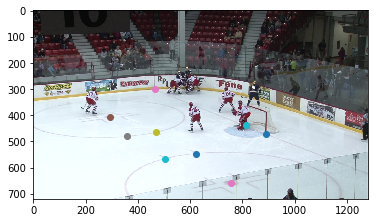

In [12]:
# read in known locations

# print(data['Label'])
pts = rink_locs[0]
for feature in key_loc_pairs.keys():
    loc = key_loc_pairs[feature]
    x,y = pts[loc]
    if x != -1 and y != -1:
        plt.scatter(x,y, label= feature)
#     print( value )
plt.imshow(mpimg.imread( os.path.join(IMAGE_DIR, image_list[0]) ))



images = [mpimg.imread(os.path.join(IMAGE_DIR, im_name)) for im_name in image_list] #[mpimg.imread(os.path.join(IMAGE_DIR, im_name)) for im_name in image_names]




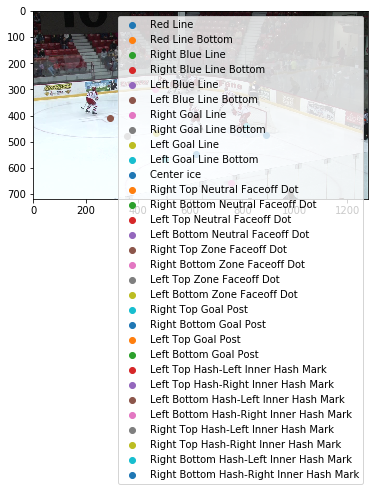

In [13]:
for feature in key_loc_pairs.keys():
    loc = key_loc_pairs[feature]
    x,y = pts[loc]
    if x != -1 and y != -1:
        plt.scatter(x,y, label= feature)
plt.legend()
plt.imshow(mpimg.imread( os.path.join(IMAGE_DIR, image_list[0]) ))

In [34]:
#Create Tensorflow Datasets for Training and Validation
batchSize = 5
# seq_len = 30
outputs = (len(known_rink_locs), 2)

IMAGE_DIR = os.path.abspath("./RushPlay2/")
# print(os.listdir(IMAGE_DIR))
# images = [mpimg.imread(os.path.join(IMAGE_DIR, im)) for im in data['External ID'][:3]]

# transfer_values = inception.process_images(inception.transfer_values, images= images)
# image_data = np.array([model.transfer_values(image= image_) for image_ in images])
# transfer_values = model.process_images(transfer_values_cache(),  )
# transfer_values = model_TL.transfer_values(images= gt_im)
# tv_size = image_data.shape[-1]
tv_size = 2048
loc_len = len(known_rink_locs)

#Define variables
# x = tf.placeholder(shape=[None, seq_len, 64, 64, 3], dtype=tf.float32) 
x = tf.placeholder(shape= [None, tv_size], dtype= tf.float32)
y = tf.placeholder(shape=[None, loc_len, 2], dtype=tf.int32) 
y_in_img = tf.placeholder(shape= [None, loc_len], dtype= tf.float32)
y_float = tf.cast(y, dtype= tf.float32)


In [27]:
X_train_ims, X_test_ims, Y_in_image_train, Y_in_image_test, Y_train, Y_test =  train_test_split(images, y_in_image, rink_locs, test_size=0.2, random_state=42)
X_train = np.array([model.transfer_values(image= image_) for image_ in X_train_ims])
X_test = np.array([model.transfer_values(image= image_) for image_ in X_test_ims])
print(X_train.shape, X_test.shape)





(104, 2048) (27, 2048)


In [28]:
def plots(lossArrs, distArrs, valItrs, itr, save= False):
    plt.figure()
    #plt.subplot(211)
    line1 = plt.plot(range(itr), lossArrs[0], label="Train loss vals")
    # Create a legend for the first line.
    #first_legend = plt.legend( handles=[line1], loc=1 )
    #plt.subplot(212)
    plt.plot(valItrs, lossArrs[1], label="Val loss values")
    plt.title("Mean Squared Error Loss over Iterations for Validation and Training Data\n")
    plt.xlabel("Iterations")
    plt.ylabel("Loss Value")
    plt.legend(loc='upper right')
    if save:
        plt.savefig(graph_path + "Loss_v_Iteration")
    else:
        plt.show()
        
        
    plt.figure()
    #plt.subplot(275)
    plt.plot(range(itr), distArrs[0], label= "Train avg distance errors")
    plt.plot(valItrs, distArrs[1], label = "Val avg distance errors")
    plt.title("Average Distance Error over Iterations for Validation and Training Data\n")
    plt.xlabel("Iterations")
    plt.ylabel("Average Distance Value")
    plt.legend(loc='upper right')
    if save:
        plt.savefig(graph_path+"AvgDst_v_Iteration")
    else:
        plt.show()
        
#     xAxis = np.arange(0, 20.5, .5)
#     print xAxis
#     yVals = [[], [], [], [], [], [], []]
#     #print finalValPtDiff
#     #size = float(finalValPtDiff.size)
#     labels = ["head", "right shoulder", "left shoulder", "righ wrist", "left wrist", "right elbow", "left elbow"]
#     for val in xAxis:
#         for i in range(len(labels)):
#             temp = np.copy(finalValPtDiff)[:,:,i]
#             #print temp.shape
#             temp[ temp < val] = 0
#             #print temp
#             count = np.count_nonzero( temp )
#             #print count
#             yVals[i].append(1- (count/float(temp.size)))

#     plt.figure()
#     for i in range(len(labels)):
#         plt.plot(xAxis, yVals[i], label= labels[i])
#     plt.legend(loc='upper left')
#     plt.title("Accuracy Percent per Distance")
#     plt.savefig(graph_path+"Accuracy Percent per Distance")
    
    
    
    
    
    

In [29]:
W_out = weight_variable("output_weights", [tv_size, loc_len*2])
W_in_img = weight_variable("output_in_img_weights", [tv_size, loc_len])




ValueError: Variable output_weights already exists, disallowed. Did you mean to set reuse=True or reuse=tf.AUTO_REUSE in VarScope? Originally defined at:

  File "<ipython-input-5-f02305614137>", line 5, in weight_variable
    initializer=tf.contrib.layers.xavier_initializer())
  File "<ipython-input-17-0abd28bfe99c>", line 1, in <module>
    W_out = weight_variable("output_weights", [tv_size, loc_len*2])
  File "/Users/Austin_Egri/.virtualenvs/3tensorflow/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2963, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)


In [18]:
W_star = tf.identity(W_out)


In [35]:
y_hat = tf.matmul(x, W_out)
y_in_img_hat = tf.sigmoid(tf.matmul(x, W_in_img))
in_im_hat = y_in_img_hat > .5

# tf.cond(y_in_img_hat > .5, 1, 0)

y_hat = tf.reshape(y_hat, [-1, y_hat.shape[1]//2, 2])
print(y_hat)
print(y_in_img_hat)


Tensor("Reshape_4:0", shape=(?, 31, 2), dtype=float32)
Tensor("Sigmoid_2:0", shape=(?, 31), dtype=float32)


In [38]:
# loss function
eta = 1e-6
mse_loss = tf.losses.mean_squared_error(y_float*tf.reshape(y_in_img, [-1,loc_len, 1]), y_hat*tf.reshape(y_in_img, [-1,loc_len, 1]))
mse_in_img_loss = tf.losses.mean_squared_error(y_in_img, y_in_im_hat)

alpha = 1.0
train_step = tf.train.AdamOptimizer(eta).minimize(mse_loss + alpha*mse_in_img_loss)
pointDiff = tf.norm(y_hat - y_float, axis= 2)
totDiff = tf.reduce_mean(tf.reduce_mean(pointDiff, axis= 0))

predict_op = tf.cast(y_hat, dtype= tf.int64)
pred_in_image = tf.cast(in_im_hat, dtype= tf.bool)
train_step = tf.train.AdamOptimizer(1e-4).minimize(mse_loss)
print(pointDiff.shape)
print(totDiff.shape)
print(mse_loss.shape)

##########  Declare Variables for Saving ############################## 
# Save the model
tf.get_collection('validation_nodes')

# Add opts to the collection
tf.add_to_collection('validation_nodes', x)
tf.add_to_collection('validation_nodes', y)
tf.add_to_collection('validation_nodes', predict_op)
##########  End Variable Declaration for Saving ############################## 


(?, 31)
()
()


In [40]:
#########################################################
##  The Model                                          ##
#########################################################

# start training
saver = tf.train.Saver()
# Run one pass over the validation dataset.
#session.run(train_itr.initializer)
lossArrs = [[], [], []] #train, val, test
distArrs = [[], [], []] #train, val, test

minDist = [np.inf, np.inf, np.inf] #train, val, test
minLoss = [np.inf, np.inf, np.inf] #train, val, test


variableValEval = False #False for faster runtime
valEvalInterval = 300
valItrs = []
# valBatchPercent = .2
# valBatchSize = 20


sRT = time()
itr = 0
logInterval = 300
epochs = 2000
max_iterations = None #101 #200000
# keepRate = .25
accLvl = .9
batchSize = 5
save_path = "./my_model/my_model"


graph_path = "./graphs/"
#feedDictItrTrain = {xTrainPH: xTrain, yTrainPH: yTrain}

# Launch the graph in a session.
session = tf.Session()


Epoch 0, step 99,     training dist: 298.885
                            val dist: 293.245
                      training loss: 11850.5
                     validation loss: 79282.8
                  min validation dist: 293.245
                       min train dist: 237.994
                                 RT = 253.55
Epoch 1, step 96,     training dist: 317.984
                            val dist: 293.73
                      training loss: 36573.3
                     validation loss: 78752.2
                  min validation dist: 293.245
                       min train dist: 237.616
                                 RT = 253.77
Epoch 2, step 93,     training dist: 320.438
                            val dist: 294.046
                      training loss: 7294.17
                     validation loss: 78311.8
                  min validation dist: 293.245
                       min train dist: 234.608
                                 RT = 254.00
Epoch 3, step 90,     training dist: 3

Epoch 26, step 21,     training dist: 309.143
                            val dist: 302.956
                      training loss: 9491.32
                     validation loss: 68693.4
                  min validation dist: 293.245
                       min train dist: 223.325
                                 RT = 259.13
Epoch 27, step 18,     training dist: 291.212
                            val dist: 303.399
                      training loss: 39863.8
                     validation loss: 68274.9
                  min validation dist: 293.245
                       min train dist: 223.325
                                 RT = 259.30
Epoch 28, step 15,     training dist: 331.387
                            val dist: 303.601
                      training loss: 42439.5
                     validation loss: 68000
                  min validation dist: 293.245
                       min train dist: 223.325
                                 RT = 259.45
Epoch 29, step 12,     training dist

Epoch 51, step 46,     training dist: 301.132
                            val dist: 308.824
                      training loss: 24437.4
                     validation loss: 61831.6
                  min validation dist: 293.245
                       min train dist: 223.325
                                 RT = 264.18
Epoch 52, step 43,     training dist: 317.892
                            val dist: 308.843
                      training loss: 27789.3
                     validation loss: 61721.4
                  min validation dist: 293.245
                       min train dist: 223.325
                                 RT = 264.34
Epoch 53, step 40,     training dist: 304.098
                            val dist: 308.999
                      training loss: 6466.42
                     validation loss: 61516.4
                  min validation dist: 293.245
                       min train dist: 223.325
                                 RT = 264.50
Epoch 54, step 37,     training di

Epoch 76, step 71,     training dist: 299.882
                            val dist: 312.401
                      training loss: 21182.6
                     validation loss: 57445.9
                  min validation dist: 293.245
                       min train dist: 223.325
                                 RT = 269.93
Epoch 77, step 68,     training dist: 311.889
                            val dist: 312.243
                      training loss: 25216.5
                     validation loss: 57493
                  min validation dist: 293.245
                       min train dist: 223.325
                                 RT = 270.11
Epoch 78, step 65,     training dist: 346.217
                            val dist: 312.385
                      training loss: 27702.9
                     validation loss: 57291.3
                  min validation dist: 293.245
                       min train dist: 223.325
                                 RT = 270.43
Epoch 79, step 62,     training dist

Epoch 101, step 96,     training dist: 336.434
                            val dist: 313.736
                      training loss: 29096.2
                     validation loss: 54462.2
                  min validation dist: 293.245
                       min train dist: 223.325
                                 RT = 275.88
Epoch 102, step 93,     training dist: 322.997
                            val dist: 313.75
                      training loss: 26478.5
                     validation loss: 54373.7
                  min validation dist: 293.245
                       min train dist: 223.325
                                 RT = 276.03
Epoch 103, step 90,     training dist: 321.482
                            val dist: 313.677
                      training loss: 43392.6
                     validation loss: 54302.4
                  min validation dist: 293.245
                       min train dist: 223.325
                                 RT = 276.18
Epoch 104, step 87,     training

Epoch 127, step 18,     training dist: 292.598
                            val dist: 313.174
                      training loss: 12538
                     validation loss: 52307.4
                  min validation dist: 293.245
                       min train dist: 223.325
                                 RT = 280.52
Epoch 128, step 15,     training dist: 321.911
                            val dist: 313.26
                      training loss: 27988.7
                     validation loss: 52195.1
                  min validation dist: 293.245
                       min train dist: 223.325
                                 RT = 280.66
Epoch 129, step 12,     training dist: 316.516
                            val dist: 313.084
                      training loss: 28646.3
                     validation loss: 52196.3
                  min validation dist: 293.245
                       min train dist: 223.325
                                 RT = 280.83
Epoch 130, step 9,     training di

Epoch 152, step 43,     training dist: 327.605
                            val dist: 311.912
                      training loss: 12654.1
                     validation loss: 50617
                  min validation dist: 293.245
                       min train dist: 223.325
                                 RT = 284.18
Epoch 153, step 40,     training dist: 327.437
                            val dist: 311.964
                      training loss: 10279.2
                     validation loss: 50502.4
                  min validation dist: 293.245
                       min train dist: 223.325
                                 RT = 284.31
Epoch 154, step 37,     training dist: 331.928
                            val dist: 311.744
                      training loss: 10440.9
                     validation loss: 50507.3
                  min validation dist: 293.245
                       min train dist: 223.325
                                 RT = 284.47
Epoch 155, step 34,     training 

Epoch 177, step 68,     training dist: 317.57
                            val dist: 310.166
                      training loss: 22218.2
                     validation loss: 49180.1
                  min validation dist: 293.245
                       min train dist: 223.325
                                 RT = 287.84
Epoch 178, step 65,     training dist: 341.778
                            val dist: 309.884
                      training loss: 9733.63
                     validation loss: 49187
                  min validation dist: 293.245
                       min train dist: 223.325
                                 RT = 287.97
Epoch 179, step 62,     training dist: 309.198
                            val dist: 309.953
                      training loss: 15225.2
                     validation loss: 49092.5
                  min validation dist: 293.245
                       min train dist: 223.325
                                 RT = 288.11
Epoch 180, step 59,     training d

Epoch 202, step 93,     training dist: 319.542
                            val dist: 308.01
                      training loss: 32938.5
                     validation loss: 47895.8
                  min validation dist: 293.245
                       min train dist: 223.325
                                 RT = 291.39
Epoch 203, step 90,     training dist: 288.577
                            val dist: 308.101
                      training loss: 18432.4
                     validation loss: 47791.8
                  min validation dist: 293.245
                       min train dist: 223.325
                                 RT = 291.52
Epoch 204, step 87,     training dist: 293.955
                            val dist: 307.985
                      training loss: 23939.2
                     validation loss: 47781.4
                  min validation dist: 293.245
                       min train dist: 223.325
                                 RT = 291.66
Epoch 205, step 84,     training

Epoch 228, step 15,     training dist: 307.879
                            val dist: 305.598
                      training loss: 30382.4
                     validation loss: 46763.1
                  min validation dist: 293.245
                       min train dist: 223.325
                                 RT = 295.01
Epoch 229, step 12,     training dist: 301.635
                            val dist: 305.606
                      training loss: 14214.5
                     validation loss: 46681.6
                  min validation dist: 293.245
                       min train dist: 223.325
                                 RT = 295.15
Epoch 230, step 9,     training dist: 291.46
                            val dist: 305.584
                      training loss: 11541.1
                     validation loss: 46623.7
                  min validation dist: 293.245
                       min train dist: 223.325
                                 RT = 295.28
Epoch 231, step 6,     training d

Epoch 253, step 40,     training dist: 323.524
                            val dist: 302.965
                      training loss: 21630.8
                     validation loss: 45775.4
                  min validation dist: 293.245
                       min train dist: 223.325
                                 RT = 298.61
Epoch 254, step 37,     training dist: 332.22
                            val dist: 302.494
                      training loss: 24546.6
                     validation loss: 45872.2
                  min validation dist: 293.245
                       min train dist: 223.325
                                 RT = 298.74
Epoch 255, step 34,     training dist: 326.578
                            val dist: 302.647
                      training loss: 8497.86
                     validation loss: 45766.4
                  min validation dist: 293.245
                       min train dist: 223.325
                                 RT = 298.88
Epoch 256, step 31,     training

Epoch 278, step 65,     training dist: 304.732
                            val dist: 300.377
                      training loss: 9777.12
                     validation loss: 44829.5
                  min validation dist: 293.245
                       min train dist: 223.325
                                 RT = 302.17
Epoch 279, step 62,     training dist: 309.143
                            val dist: 300.293
                      training loss: 30787.2
                     validation loss: 44775.4
                  min validation dist: 293.245
                       min train dist: 223.325
                                 RT = 302.31
Epoch 280, step 59,     training dist: 312.02
                            val dist: 300.094
                      training loss: 25384.4
                     validation loss: 44771.6
                  min validation dist: 293.245
                       min train dist: 223.325
                                 RT = 302.44
Epoch 281, step 56,     training

Epoch 303, step 90,     training dist: 302.955
                            val dist: 297.765
                      training loss: 33916.7
                     validation loss: 43897.4
                  min validation dist: 293.245
                       min train dist: 223.325
                                 RT = 305.70
Epoch 304, step 87,     training dist: 290.502
                            val dist: 297.925
                      training loss: 19355.5
                     validation loss: 43769.5
                  min validation dist: 293.245
                       min train dist: 223.325
                                 RT = 305.84
Epoch 305, step 84,     training dist: 282.55
                            val dist: 297.755
                      training loss: 10382.1
                     validation loss: 43769.2
                  min validation dist: 293.245
                       min train dist: 223.325
                                 RT = 305.98
Epoch 306, step 81,     training

Epoch 329, step 12,     training dist: 281.263
                            val dist: 295.103
                      training loss: 13265.9
                     validation loss: 42986.2
                  min validation dist: 293.245
                       min train dist: 223.325
                                 RT = 309.31
Epoch 330, step 9,     training dist: 320.107
                            val dist: 294.925
                      training loss: 19285.8
                     validation loss: 42976.5
                  min validation dist: 293.245
                       min train dist: 223.325
                                 RT = 309.45
Epoch 331, step 6,     training dist: 291.346
                            val dist: 294.925
                      training loss: 19513.6
                     validation loss: 42906.7
                  min validation dist: 293.245
                       min train dist: 223.325
                                 RT = 309.59
Epoch 332, step 3,     training d

Epoch 354, step 37,     training dist: 306.871
                            val dist: 292.587
                      training loss: 28290.5
                     validation loss: 42073.5
                  min validation dist: 292.415
                       min train dist: 223.325
                                 RT = 312.95
Epoch 355, step 34,     training dist: 281.928
                            val dist: 292.603
                      training loss: 26828.8
                     validation loss: 42013.1
                  min validation dist: 292.415
                       min train dist: 223.325
                                 RT = 313.08
Epoch 356, step 31,     training dist: 313.41
                            val dist: 292.414
                      training loss: 7372.5
                     validation loss: 41999.8
                  min validation dist: 292.414
                       min train dist: 223.325
                                 RT = 313.22
Epoch 357, step 28,     training 

Epoch 379, step 62,     training dist: 258.059
                            val dist: 289.86
                      training loss: 10220.5
                     validation loss: 41247.9
                  min validation dist: 289.86
                       min train dist: 223.325
                                 RT = 316.50
Epoch 380, step 59,     training dist: 273.809
                            val dist: 289.83
                      training loss: 17741.2
                     validation loss: 41212.2
                  min validation dist: 289.83
                       min train dist: 223.325
                                 RT = 316.63
Epoch 381, step 56,     training dist: 274.419
                            val dist: 289.976
                      training loss: 9340.28
                     validation loss: 41074.3
                  min validation dist: 289.83
                       min train dist: 223.325
                                 RT = 316.77
Epoch 382, step 53,     training dis

Epoch 404, step 87,     training dist: 297.344
                            val dist: 287.044
                      training loss: 31337.4
                     validation loss: 40519.2
                  min validation dist: 287.044
                       min train dist: 223.325
                                 RT = 321.59
Epoch 405, step 84,     training dist: 274.399
                            val dist: 287.044
                      training loss: 13826.8
                     validation loss: 40460.6
                  min validation dist: 287.044
                       min train dist: 223.325
                                 RT = 321.73
Epoch 406, step 81,     training dist: 276.838
                            val dist: 286.738
                      training loss: 20087.2
                     validation loss: 40500.1
                  min validation dist: 286.738
                       min train dist: 223.325
                                 RT = 321.87
Epoch 407, step 78,     trainin

Epoch 430, step 9,     training dist: 318.69
                            val dist: 284.611
                      training loss: 28308.4
                     validation loss: 39685.9
                  min validation dist: 284.611
                       min train dist: 223.325
                                 RT = 325.86
Epoch 431, step 6,     training dist: 275.862
                            val dist: 284.526
                      training loss: 11767.5
                     validation loss: 39644.6
                  min validation dist: 284.526
                       min train dist: 223.325
                                 RT = 326.00
Epoch 432, step 3,     training dist: 260.167
                            val dist: 284.521
                      training loss: 14780.7
                     validation loss: 39583.7
                  min validation dist: 284.521
                       min train dist: 223.325
                                 RT = 326.14
Epoch 433, step 0,     training dis

Epoch 455, step 34,     training dist: 239.333
                            val dist: 281.597
                      training loss: 9617.92
                     validation loss: 39014.8
                  min validation dist: 281.597
                       min train dist: 223.325
                                 RT = 330.13
Epoch 456, step 31,     training dist: 271.485
                            val dist: 281.573
                      training loss: 8209.64
                     validation loss: 38983.5
                  min validation dist: 281.573
                       min train dist: 223.325
                                 RT = 330.39
Epoch 457, step 28,     training dist: 277.244
                            val dist: 281.467
                      training loss: 28900
                     validation loss: 38976.2
                  min validation dist: 281.467
                       min train dist: 223.325
                                 RT = 330.53
Epoch 458, step 25,     training 

Epoch 480, step 59,     training dist: 261.253
                            val dist: 279.242
                      training loss: 10993.9
                     validation loss: 38222.3
                  min validation dist: 279.242
                       min train dist: 223.325
                                 RT = 333.87
Epoch 481, step 56,     training dist: 309.173
                            val dist: 279.215
                      training loss: 13560.2
                     validation loss: 38193
                  min validation dist: 279.215
                       min train dist: 223.325
                                 RT = 334.01
Epoch 482, step 53,     training dist: 303.216
                            val dist: 279.029
                      training loss: 9208.79
                     validation loss: 38188.3
                  min validation dist: 279.029
                       min train dist: 223.325
                                 RT = 334.15
Epoch 483, step 50,     training 

Epoch 505, step 84,     training dist: 281.933
                            val dist: 276.587
                      training loss: 16457.5
                     validation loss: 37590.5
                  min validation dist: 276.587
                       min train dist: 223.325
                                 RT = 337.88
Epoch 506, step 81,     training dist: 266.839
                            val dist: 276.553
                      training loss: 8786.65
                     validation loss: 37535.8
                  min validation dist: 276.553
                       min train dist: 223.325
                                 RT = 338.01
Epoch 507, step 78,     training dist: 291.279
                            val dist: 276.613
                      training loss: 18919.1
                     validation loss: 37472.2
                  min validation dist: 276.553
                       min train dist: 223.325
                                 RT = 338.16
Epoch 508, step 75,     trainin

Epoch 531, step 6,     training dist: 269.589
                            val dist: 274.524
                      training loss: 23056
                     validation loss: 36766.7
                  min validation dist: 274.524
                       min train dist: 222.83
                                 RT = 342.12
Epoch 532, step 3,     training dist: 284.43
                            val dist: 274.473
                      training loss: 7558.15
                     validation loss: 36735.9
                  min validation dist: 274.473
                       min train dist: 222.83
                                 RT = 342.27
Epoch 533, step 0,     training dist: 303.365
                            val dist: 274.275
                      training loss: 26602.2
                     validation loss: 36733.4
                  min validation dist: 274.275
                       min train dist: 222.83
                                 RT = 342.41
Epoch 533, step 100,     training dist: 

Epoch 556, step 31,     training dist: 264.977
                            val dist: 272.002
                      training loss: 25853.8
                     validation loss: 36111.3
                  min validation dist: 272.002
                       min train dist: 219.342
                                 RT = 346.42
Epoch 557, step 28,     training dist: 251.325
                            val dist: 271.705
                      training loss: 9752.13
                     validation loss: 36125.6
                  min validation dist: 271.705
                       min train dist: 219.342
                                 RT = 346.56
Epoch 558, step 25,     training dist: 285.007
                            val dist: 271.808
                      training loss: 16569.1
                     validation loss: 36047.9
                  min validation dist: 271.705
                       min train dist: 219.342
                                 RT = 346.70
Epoch 559, step 22,     trainin

Epoch 581, step 56,     training dist: 257.246
                            val dist: 269.693
                      training loss: 16514.8
                     validation loss: 35393.6
                  min validation dist: 269.63
                       min train dist: 205.126
                                 RT = 350.50
Epoch 582, step 53,     training dist: 264.275
                            val dist: 269.468
                      training loss: 19747.8
                     validation loss: 35431.7
                  min validation dist: 269.468
                       min train dist: 205.126
                                 RT = 350.65
Epoch 583, step 50,     training dist: 285.579
                            val dist: 269.488
                      training loss: 25930.6
                     validation loss: 35377
                  min validation dist: 269.468
                       min train dist: 205.126
                                 RT = 350.79
Epoch 584, step 47,     training d

Epoch 606, step 81,     training dist: 289.844
                            val dist: 267.43
                      training loss: 13035.5
                     validation loss: 34749.3
                  min validation dist: 267.43
                       min train dist: 199.942
                                 RT = 354.64
Epoch 607, step 78,     training dist: 306.507
                            val dist: 267.083
                      training loss: 4623.01
                     validation loss: 34791.6
                  min validation dist: 267.083
                       min train dist: 199.942
                                 RT = 354.78
Epoch 608, step 75,     training dist: 248.775
                            val dist: 267.029
                      training loss: 8137.76
                     validation loss: 34755.6
                  min validation dist: 267.029
                       min train dist: 199.942
                                 RT = 354.92
Epoch 609, step 72,     training 

Epoch 632, step 3,     training dist: 260.184
                            val dist: 265.191
                      training loss: 6918.3
                     validation loss: 34119.4
                  min validation dist: 265.191
                       min train dist: 199.942
                                 RT = 358.93
Epoch 633, step 0,     training dist: 251.564
                            val dist: 265.213
                      training loss: 18187.4
                     validation loss: 34060.4
                  min validation dist: 265.191
                       min train dist: 199.942
                                 RT = 359.19
Epoch 633, step 100,     training dist: 285.488
                            val dist: 265.072
                      training loss: 6444.98
                     validation loss: 34056.6
                  min validation dist: 265.072
                       min train dist: 199.942
                                 RT = 359.33
Epoch 634, step 97,     training 

Epoch 657, step 28,     training dist: 277.271
                            val dist: 262.926
                      training loss: 15680
                     validation loss: 33519.1
                  min validation dist: 262.926
                       min train dist: 199.942
                                 RT = 363.40
Epoch 658, step 25,     training dist: 239.11
                            val dist: 262.907
                      training loss: 7253.14
                     validation loss: 33473.3
                  min validation dist: 262.907
                       min train dist: 199.942
                                 RT = 363.56
Epoch 659, step 22,     training dist: 255.735
                            val dist: 262.887
                      training loss: 5691.11
                     validation loss: 33434.8
                  min validation dist: 262.887
                       min train dist: 199.942
                                 RT = 363.73
Epoch 660, step 19,     training d

Epoch 682, step 53,     training dist: 276.625
                            val dist: 260.899
                      training loss: 37394.9
                     validation loss: 32895.6
                  min validation dist: 260.899
                       min train dist: 195.926
                                 RT = 368.35
Epoch 683, step 50,     training dist: 217.003
                            val dist: 260.896
                      training loss: 7965.93
                     validation loss: 32890.5
                  min validation dist: 260.896
                       min train dist: 195.926
                                 RT = 368.62
Epoch 684, step 47,     training dist: 260.942
                            val dist: 260.681
                      training loss: 18499.6
                     validation loss: 32894.1
                  min validation dist: 260.681
                       min train dist: 195.926
                                 RT = 368.81
Epoch 685, step 44,     trainin

Epoch 707, step 78,     training dist: 247.739
                            val dist: 258.927
                      training loss: 19300.5
                     validation loss: 32325.9
                  min validation dist: 258.927
                       min train dist: 195.926
                                 RT = 374.46
Epoch 708, step 75,     training dist: 246.243
                            val dist: 258.782
                      training loss: 11095.7
                     validation loss: 32323.7
                  min validation dist: 258.782
                       min train dist: 195.926
                                 RT = 374.62
Epoch 709, step 72,     training dist: 253.882
                            val dist: 258.787
                      training loss: 12967
                     validation loss: 32285
                  min validation dist: 258.782
                       min train dist: 195.926
                                 RT = 374.78
Epoch 710, step 69,     training di

Epoch 733, step 0,     training dist: 237.308
                            val dist: 256.655
                      training loss: 12515.9
                     validation loss: 31799.8
                  min validation dist: 256.655
                       min train dist: 193.704
                                 RT = 378.76
Epoch 733, step 100,     training dist: 223.404
                            val dist: 256.648
                      training loss: 10981.5
                     validation loss: 31755.6
                  min validation dist: 256.648
                       min train dist: 193.704
                                 RT = 378.93
Epoch 734, step 97,     training dist: 274.854
                            val dist: 256.477
                      training loss: 9259.58
                     validation loss: 31758.7
                  min validation dist: 256.477
                       min train dist: 193.704
                                 RT = 379.07
Epoch 735, step 94,     trainin

Epoch 758, step 25,     training dist: 215.321
                            val dist: 254.621
                      training loss: 8713.03
                     validation loss: 31255.2
                  min validation dist: 254.621
                       min train dist: 181.416
                                 RT = 383.28
Epoch 759, step 22,     training dist: 247.353
                            val dist: 254.632
                      training loss: 11644.9
                     validation loss: 31205.8
                  min validation dist: 254.621
                       min train dist: 181.416
                                 RT = 383.58
Epoch 760, step 19,     training dist: 256.989
                            val dist: 254.581
                      training loss: 18452.1
                     validation loss: 31180
                  min validation dist: 254.581
                       min train dist: 181.416
                                 RT = 383.87
Epoch 761, step 16,     training 

Epoch 783, step 50,     training dist: 254.239
                            val dist: 252.55
                      training loss: 12395.2
                     validation loss: 30732.2
                  min validation dist: 252.55
                       min train dist: 170.765
                                 RT = 389.33
Epoch 784, step 47,     training dist: 215.649
                            val dist: 252.491
                      training loss: 6974.79
                     validation loss: 30710.1
                  min validation dist: 252.491
                       min train dist: 170.765
                                 RT = 389.48
Epoch 785, step 44,     training dist: 268.305
                            val dist: 252.524
                      training loss: 10971.5
                     validation loss: 30668.7
                  min validation dist: 252.491
                       min train dist: 170.765
                                 RT = 389.63
Epoch 786, step 41,     training 

Epoch 808, step 75,     training dist: 225.227
                            val dist: 250.681
                      training loss: 13563
                     validation loss: 30227
                  min validation dist: 250.681
                       min train dist: 170.765
                                 RT = 393.61
Epoch 809, step 72,     training dist: 240.032
                            val dist: 250.583
                      training loss: 1696.78
                     validation loss: 30203.1
                  min validation dist: 250.583
                       min train dist: 170.765
                                 RT = 393.84
Epoch 810, step 69,     training dist: 263.916
                            val dist: 250.557
                      training loss: 17274.9
                     validation loss: 30177.1
                  min validation dist: 250.557
                       min train dist: 170.765
                                 RT = 394.10
Epoch 811, step 66,     training di

Epoch 833, step 100,     training dist: 248.521
                            val dist: 248.877
                      training loss: 10869.3
                     validation loss: 29680
                  min validation dist: 248.877
                       min train dist: 167.828
                                 RT = 398.32
Epoch 834, step 97,     training dist: 261.735
                            val dist: 248.726
                      training loss: 10923.1
                     validation loss: 29697.9
                  min validation dist: 248.726
                       min train dist: 167.828
                                 RT = 398.45
Epoch 835, step 94,     training dist: 262.657
                            val dist: 248.754
                      training loss: 26462.4
                     validation loss: 29646.6
                  min validation dist: 248.726
                       min train dist: 167.828
                                 RT = 398.59
Epoch 836, step 91,     training

Epoch 859, step 22,     training dist: 266.062
                            val dist: 247.015
                      training loss: 12529.5
                     validation loss: 29226.1
                  min validation dist: 246.901
                       min train dist: 167.828
                                 RT = 401.87
Epoch 860, step 19,     training dist: 214.973
                            val dist: 246.968
                      training loss: 10281.3
                     validation loss: 29215.1
                  min validation dist: 246.901
                       min train dist: 167.828
                                 RT = 402.01
Epoch 861, step 16,     training dist: 292.893
                            val dist: 246.779
                      training loss: 21303.8
                     validation loss: 29203.4
                  min validation dist: 246.779
                       min train dist: 167.828
                                 RT = 402.14
Epoch 862, step 13,     trainin

Epoch 884, step 47,     training dist: 270.236
                            val dist: 245.386
                      training loss: 6660.3
                     validation loss: 28701.6
                  min validation dist: 245.187
                       min train dist: 167.828
                                 RT = 405.51
Epoch 885, step 44,     training dist: 221.083
                            val dist: 245.147
                      training loss: 19931.6
                     validation loss: 28721.2
                  min validation dist: 245.147
                       min train dist: 167.828
                                 RT = 405.65
Epoch 886, step 41,     training dist: 243.183
                            val dist: 245.082
                      training loss: 13213.3
                     validation loss: 28718.1
                  min validation dist: 245.082
                       min train dist: 167.828
                                 RT = 405.79
Epoch 887, step 38,     training

Epoch 909, step 72,     training dist: 261.27
                            val dist: 243.553
                      training loss: 5189.74
                     validation loss: 28263.3
                  min validation dist: 243.553
                       min train dist: 167.828
                                 RT = 409.08
Epoch 910, step 69,     training dist: 233.38
                            val dist: 243.374
                      training loss: 12877.2
                     validation loss: 28293.8
                  min validation dist: 243.374
                       min train dist: 167.828
                                 RT = 409.22
Epoch 911, step 66,     training dist: 252.263
                            val dist: 243.373
                      training loss: 12136.5
                     validation loss: 28243.4
                  min validation dist: 243.373
                       min train dist: 167.828
                                 RT = 409.36
Epoch 912, step 63,     training 

Epoch 934, step 97,     training dist: 205.045
                            val dist: 241.699
                      training loss: 9816.01
                     validation loss: 27866.6
                  min validation dist: 241.699
                       min train dist: 165.023
                                 RT = 413.09
Epoch 935, step 94,     training dist: 227.644
                            val dist: 241.692
                      training loss: 3110.2
                     validation loss: 27842.8
                  min validation dist: 241.692
                       min train dist: 165.023
                                 RT = 413.35
Epoch 936, step 91,     training dist: 213.29
                            val dist: 241.376
                      training loss: 16968.8
                     validation loss: 27885.6
                  min validation dist: 241.376
                       min train dist: 165.023
                                 RT = 413.60
Epoch 937, step 88,     training 

Epoch 960, step 19,     training dist: 172.964
                            val dist: 240.154
                      training loss: 5052.44
                     validation loss: 27426.4
                  min validation dist: 240.154
                       min train dist: 165.023
                                 RT = 419.08
Epoch 961, step 16,     training dist: 226.314
                            val dist: 239.97
                      training loss: 9238.83
                     validation loss: 27451.9
                  min validation dist: 239.97
                       min train dist: 165.023
                                 RT = 419.23
Epoch 962, step 13,     training dist: 250.189
                            val dist: 239.921
                      training loss: 8552.09
                     validation loss: 27418.6
                  min validation dist: 239.921
                       min train dist: 165.023
                                 RT = 419.39
Epoch 963, step 10,     training 

Epoch 985, step 44,     training dist: 271.052
                            val dist: 238.44
                      training loss: 7841.41
                     validation loss: 27023.2
                  min validation dist: 238.44
                       min train dist: 160.112
                                 RT = 423.02
Epoch 986, step 41,     training dist: 191.028
                            val dist: 238.438
                      training loss: 6161.8
                     validation loss: 26993.4
                  min validation dist: 238.438
                       min train dist: 160.112
                                 RT = 423.18
Epoch 987, step 38,     training dist: 205.141
                            val dist: 238.193
                      training loss: 14484.2
                     validation loss: 27021.2
                  min validation dist: 238.193
                       min train dist: 160.112
                                 RT = 423.33
Epoch 988, step 35,     training d

Epoch 1010, step 69,     training dist: 229.051
                            val dist: 236.9
                      training loss: 5001.87
                     validation loss: 26613
                  min validation dist: 236.714
                       min train dist: 160.112
                                 RT = 428.07
Epoch 1011, step 66,     training dist: 238.606
                            val dist: 236.714
                      training loss: 2868.86
                     validation loss: 26623.3
                  min validation dist: 236.714
                       min train dist: 160.112
                                 RT = 428.23
Epoch 1012, step 63,     training dist: 247.571
                            val dist: 236.471
                      training loss: 5833.67
                     validation loss: 26684.3
                  min validation dist: 236.471
                       min train dist: 160.112
                                 RT = 428.41
Epoch 1013, step 60,     trainin

Epoch 1035, step 94,     training dist: 222.486
                            val dist: 235.262
                      training loss: 17705.5
                     validation loss: 26234
                  min validation dist: 235.262
                       min train dist: 154.857
                                 RT = 434.03
Epoch 1036, step 91,     training dist: 207.506
                            val dist: 235.17
                      training loss: 11924.3
                     validation loss: 26248.5
                  min validation dist: 235.17
                       min train dist: 154.857
                                 RT = 434.38
Epoch 1037, step 88,     training dist: 236.944
                            val dist: 235.26
                      training loss: 16434.4
                     validation loss: 26185.2
                  min validation dist: 235.17
                       min train dist: 154.857
                                 RT = 434.77
Epoch 1038, step 85,     training 

Epoch 1061, step 16,     training dist: 226.198
                            val dist: 233.756
                      training loss: 5665.19
                     validation loss: 25874.2
                  min validation dist: 233.756
                       min train dist: 154.857
                                 RT = 440.10
Epoch 1062, step 13,     training dist: 202.006
                            val dist: 233.715
                      training loss: 15889.3
                     validation loss: 25857.6
                  min validation dist: 233.715
                       min train dist: 154.857
                                 RT = 440.26
Epoch 1063, step 10,     training dist: 243.349
                            val dist: 233.664
                      training loss: 12628.7
                     validation loss: 25834
                  min validation dist: 233.664
                       min train dist: 154.857
                                 RT = 440.41
Epoch 1064, step 7,     traini

Epoch 1086, step 41,     training dist: 233.91
                            val dist: 232.498
                      training loss: 7970.16
                     validation loss: 25449.5
                  min validation dist: 232.377
                       min train dist: 142.574
                                 RT = 444.74
Epoch 1087, step 38,     training dist: 192.078
                            val dist: 232.532
                      training loss: 3377.65
                     validation loss: 25386.2
                  min validation dist: 232.377
                       min train dist: 142.574
                                 RT = 444.91
Epoch 1088, step 35,     training dist: 244.872
                            val dist: 232.469
                      training loss: 7877.94
                     validation loss: 25380.6
                  min validation dist: 232.377
                       min train dist: 142.574
                                 RT = 445.10
Epoch 1089, step 32,     trai

Epoch 1111, step 66,     training dist: 240.774
                            val dist: 231.103
                      training loss: 4538.19
                     validation loss: 25058.9
                  min validation dist: 230.999
                       min train dist: 142.574
                                 RT = 450.37
Epoch 1112, step 63,     training dist: 268.853
                            val dist: 230.837
                      training loss: 5163.09
                     validation loss: 25118.8
                  min validation dist: 230.837
                       min train dist: 142.574
                                 RT = 450.61
Epoch 1113, step 60,     training dist: 172.949
                            val dist: 230.928
                      training loss: 7036.56
                     validation loss: 25043.2
                  min validation dist: 230.837
                       min train dist: 142.574
                                 RT = 450.84
Epoch 1114, step 57,     tra

Epoch 1136, step 91,     training dist: 234.619
                            val dist: 229.71
                      training loss: 5944.9
                     validation loss: 24712.8
                  min validation dist: 229.614
                       min train dist: 142.574
                                 RT = 456.21
Epoch 1137, step 88,     training dist: 217.328
                            val dist: 229.463
                      training loss: 11183.5
                     validation loss: 24753.5
                  min validation dist: 229.463
                       min train dist: 142.574
                                 RT = 456.41
Epoch 1138, step 85,     training dist: 204.903
                            val dist: 229.595
                      training loss: 12197.2
                     validation loss: 24678.8
                  min validation dist: 229.463
                       min train dist: 142.574
                                 RT = 456.58
Epoch 1139, step 82,     train

Epoch 1162, step 13,     training dist: 241.536
                            val dist: 228.211
                      training loss: 3019.1
                     validation loss: 24418.8
                  min validation dist: 228.209
                       min train dist: 142.574
                                 RT = 461.81
Epoch 1163, step 10,     training dist: 264.816
                            val dist: 228.179
                      training loss: 8097.7
                     validation loss: 24395.4
                  min validation dist: 228.179
                       min train dist: 142.574
                                 RT = 462.01
Epoch 1164, step 7,     training dist: 244.72
                            val dist: 228.141
                      training loss: 5370.48
                     validation loss: 24375.3
                  min validation dist: 228.141
                       min train dist: 142.574
                                 RT = 462.24
Epoch 1165, step 4,     training

Epoch 1187, step 38,     training dist: 254.872
                            val dist: 226.885
                      training loss: 15123.9
                     validation loss: 24097.4
                  min validation dist: 226.856
                       min train dist: 142.574
                                 RT = 468.56
Epoch 1188, step 35,     training dist: 156.719
                            val dist: 226.745
                      training loss: 7102.41
                     validation loss: 24123.6
                  min validation dist: 226.745
                       min train dist: 142.574
                                 RT = 468.70
Epoch 1189, step 32,     training dist: 212.016
                            val dist: 226.899
                      training loss: 13200.6
                     validation loss: 24051.2
                  min validation dist: 226.745
                       min train dist: 142.574
                                 RT = 468.99
Epoch 1190, step 29,     tra

Epoch 1212, step 63,     training dist: 223.431
                            val dist: 225.476
                      training loss: 9122.09
                     validation loss: 23803.3
                  min validation dist: 225.335
                       min train dist: 142.574
                                 RT = 474.31
Epoch 1213, step 60,     training dist: 233.204
                            val dist: 225.588
                      training loss: 5433.41
                     validation loss: 23740.5
                  min validation dist: 225.335
                       min train dist: 142.574
                                 RT = 474.45
Epoch 1214, step 57,     training dist: 190.284
                            val dist: 225.289
                      training loss: 6184.37
                     validation loss: 23816.7
                  min validation dist: 225.289
                       min train dist: 142.574
                                 RT = 474.59
Epoch 1215, step 54,     tra

Epoch 1237, step 88,     training dist: 212.861
                            val dist: 224.453
                      training loss: 9565.51
                     validation loss: 23443.1
                  min validation dist: 224.432
                       min train dist: 142.574
                                 RT = 479.21
Epoch 1238, step 85,     training dist: 230.35
                            val dist: 224.412
                      training loss: 4370.69
                     validation loss: 23430.2
                  min validation dist: 224.412
                       min train dist: 142.574
                                 RT = 479.44
Epoch 1239, step 82,     training dist: 237.478
                            val dist: 224.331
                      training loss: 5567
                     validation loss: 23430.1
                  min validation dist: 224.331
                       min train dist: 142.574
                                 RT = 479.69
Epoch 1240, step 79,     trainin

Epoch 1263, step 10,     training dist: 209.247
                            val dist: 223.307
                      training loss: 8314.26
                     validation loss: 23108.6
                  min validation dist: 223.266
                       min train dist: 142.574
                                 RT = 483.39
Epoch 1264, step 7,     training dist: 224.761
                            val dist: 223.215
                      training loss: 17223
                     validation loss: 23117.5
                  min validation dist: 223.215
                       min train dist: 142.574
                                 RT = 483.53
Epoch 1265, step 4,     training dist: 207.41
                            val dist: 223.184
                      training loss: 1573.38
                     validation loss: 23107.2
                  min validation dist: 223.184
                       min train dist: 142.574
                                 RT = 483.67
Epoch 1266, step 1,     training 

Epoch 1288, step 35,     training dist: 178.332
                            val dist: 222.071
                      training loss: 2616.69
                     validation loss: 22823.9
                  min validation dist: 221.998
                       min train dist: 142.574
                                 RT = 487.01
Epoch 1289, step 32,     training dist: 227.988
                            val dist: 221.98
                      training loss: 7282.59
                     validation loss: 22854.1
                  min validation dist: 221.98
                       min train dist: 142.574
                                 RT = 487.17
Epoch 1290, step 29,     training dist: 218.162
                            val dist: 221.807
                      training loss: 5596.53
                     validation loss: 22871.1
                  min validation dist: 221.807
                       min train dist: 142.574
                                 RT = 487.35
Epoch 1291, step 26,     train

Epoch 1313, step 60,     training dist: 168.293
                            val dist: 220.667
                      training loss: 3203.1
                     validation loss: 22612.3
                  min validation dist: 220.561
                       min train dist: 138.439
                                 RT = 492.81
Epoch 1314, step 57,     training dist: 221.008
                            val dist: 220.722
                      training loss: 8322.14
                     validation loss: 22574.1
                  min validation dist: 220.561
                       min train dist: 138.439
                                 RT = 493.05
Epoch 1315, step 54,     training dist: 236.921
                            val dist: 220.678
                      training loss: 5994.98
                     validation loss: 22579.9
                  min validation dist: 220.561
                       min train dist: 138.439
                                 RT = 493.31
Epoch 1316, step 51,     trai

Epoch 1338, step 85,     training dist: 218.566
                            val dist: 219.516
                      training loss: 5846.66
                     validation loss: 22353.9
                  min validation dist: 219.482
                       min train dist: 138.439
                                 RT = 499.01
Epoch 1339, step 82,     training dist: 261.053
                            val dist: 219.465
                      training loss: 6818.85
                     validation loss: 22332.9
                  min validation dist: 219.465
                       min train dist: 138.439
                                 RT = 499.22
Epoch 1340, step 79,     training dist: 240.313
                            val dist: 219.47
                      training loss: 7562.52
                     validation loss: 22318.4
                  min validation dist: 219.465
                       min train dist: 138.439
                                 RT = 499.39
Epoch 1341, step 76,     trai

Epoch 1364, step 7,     training dist: 238.935
                            val dist: 218.366
                      training loss: 11478.4
                     validation loss: 22111.7
                  min validation dist: 218.366
                       min train dist: 130.327
                                 RT = 505.22
Epoch 1365, step 4,     training dist: 217.252
                            val dist: 218.381
                      training loss: 10510.1
                     validation loss: 22086.1
                  min validation dist: 218.366
                       min train dist: 130.327
                                 RT = 505.43
Epoch 1366, step 1,     training dist: 251.24
                            val dist: 218.372
                      training loss: 8297.76
                     validation loss: 22069.8
                  min validation dist: 218.366
                       min train dist: 130.327
                                 RT = 505.60
Epoch 1366, step 101,     traini

Epoch 1389, step 32,     training dist: 222.181
                            val dist: 217.372
                      training loss: 4086.94
                     validation loss: 21830.2
                  min validation dist: 217.372
                       min train dist: 130.327
                                 RT = 510.46
Epoch 1390, step 29,     training dist: 201.182
                            val dist: 217.386
                      training loss: 5707.76
                     validation loss: 21797.4
                  min validation dist: 217.372
                       min train dist: 130.327
                                 RT = 510.65
Epoch 1391, step 26,     training dist: 167.353
                            val dist: 217.432
                      training loss: 2304.78
                     validation loss: 21771.8
                  min validation dist: 217.372
                       min train dist: 130.327
                                 RT = 510.82
Epoch 1392, step 23,     tra

Epoch 1414, step 57,     training dist: 190.027
                            val dist: 216.412
                      training loss: 7315.32
                     validation loss: 21559.6
                  min validation dist: 216.353
                       min train dist: 129.21
                                 RT = 515.27
Epoch 1415, step 54,     training dist: 183.315
                            val dist: 216.267
                      training loss: 9907.2
                     validation loss: 21581.9
                  min validation dist: 216.267
                       min train dist: 129.21
                                 RT = 515.54
Epoch 1416, step 51,     training dist: 183.051
                            val dist: 216.181
                      training loss: 4424.59
                     validation loss: 21581.2
                  min validation dist: 216.181
                       min train dist: 129.21
                                 RT = 515.80
Epoch 1417, step 48,     trainin

Epoch 1439, step 82,     training dist: 207.98
                            val dist: 215.221
                      training loss: 11324.5
                     validation loss: 21355
                  min validation dist: 215.217
                       min train dist: 128.848
                                 RT = 522.61
Epoch 1440, step 79,     training dist: 187.999
                            val dist: 215.295
                      training loss: 1474.92
                     validation loss: 21316.5
                  min validation dist: 215.217
                       min train dist: 128.848
                                 RT = 522.88
Epoch 1441, step 76,     training dist: 169.645
                            val dist: 215.118
                      training loss: 7465.44
                     validation loss: 21345.2
                  min validation dist: 215.118
                       min train dist: 128.848
                                 RT = 523.23
Epoch 1442, step 73,     traini

Epoch 1465, step 4,     training dist: 226.66
                            val dist: 214.296
                      training loss: 6812.87
                     validation loss: 21109.5
                  min validation dist: 214.296
                       min train dist: 128.848
                                 RT = 531.16
Epoch 1466, step 1,     training dist: 180.658
                            val dist: 214.348
                      training loss: 1322.43
                     validation loss: 21071
                  min validation dist: 214.296
                       min train dist: 128.848
                                 RT = 531.42
Epoch 1466, step 101,     training dist: 220.107
                            val dist: 214.312
                      training loss: 885.363
                     validation loss: 21061.2
                  min validation dist: 214.296
                       min train dist: 128.848
                                 RT = 531.79
Epoch 1467, step 98,     trainin

Epoch 1490, step 29,     training dist: 185.346
                            val dist: 213.145
                      training loss: 1959.32
                     validation loss: 20923.8
                  min validation dist: 213.131
                       min train dist: 121.423
                                 RT = 538.09
Epoch 1491, step 26,     training dist: 196.263
                            val dist: 213.195
                      training loss: 10011.3
                     validation loss: 20903.1
                  min validation dist: 213.131
                       min train dist: 121.423
                                 RT = 538.34
Epoch 1492, step 23,     training dist: 163.767
                            val dist: 213.176
                      training loss: 3684.52
                     validation loss: 20874.6
                  min validation dist: 213.131
                       min train dist: 121.423
                                 RT = 538.56
Epoch 1493, step 20,     tra

Epoch 1515, step 54,     training dist: 204.785
                            val dist: 212.162
                      training loss: 7446.25
                     validation loss: 20720.3
                  min validation dist: 212.162
                       min train dist: 121.423
                                 RT = 543.95
Epoch 1516, step 51,     training dist: 221.313
                            val dist: 212.165
                      training loss: 16501.7
                     validation loss: 20696.3
                  min validation dist: 212.162
                       min train dist: 121.423
                                 RT = 544.14
Epoch 1517, step 48,     training dist: 205.298
                            val dist: 212.132
                      training loss: 6578.53
                     validation loss: 20678.5
                  min validation dist: 212.132
                       min train dist: 121.423
                                 RT = 544.31
Epoch 1518, step 45,     tra

Epoch 1540, step 79,     training dist: 176.636
                            val dist: 211.176
                      training loss: 4540.15
                     validation loss: 20495.4
                  min validation dist: 211.176
                       min train dist: 121.423
                                 RT = 548.17
Epoch 1541, step 76,     training dist: 173.495
                            val dist: 211.129
                      training loss: 9383.42
                     validation loss: 20499.2
                  min validation dist: 211.129
                       min train dist: 121.423
                                 RT = 548.33
Epoch 1542, step 73,     training dist: 190.619
                            val dist: 211.18
                      training loss: 6185.17
                     validation loss: 20469.1
                  min validation dist: 211.129
                       min train dist: 121.423
                                 RT = 548.50
Epoch 1543, step 70,     trai

Epoch 1566, step 1,     training dist: 211.505
                            val dist: 210.391
                      training loss: 4904.23
                     validation loss: 20249.1
                  min validation dist: 210.391
                       min train dist: 116.5
                                 RT = 552.16
Epoch 1566, step 101,     training dist: 208.448
                            val dist: 210.425
                      training loss: 2105.12
                     validation loss: 20225.5
                  min validation dist: 210.391
                       min train dist: 116.5
                                 RT = 552.31
Epoch 1567, step 98,     training dist: 266.384
                            val dist: 210.397
                      training loss: 7520.07
                     validation loss: 20216.6
                  min validation dist: 210.391
                       min train dist: 116.5
                                 RT = 552.46
Epoch 1568, step 95,     training 

Epoch 1591, step 26,     training dist: 231.233
                            val dist: 209.472
                      training loss: 6343.9
                     validation loss: 20070.2
                  min validation dist: 209.472
                       min train dist: 110.989
                                 RT = 556.01
Epoch 1592, step 23,     training dist: 171.518
                            val dist: 209.557
                      training loss: 8236.75
                     validation loss: 20027.3
                  min validation dist: 209.472
                       min train dist: 110.989
                                 RT = 556.18
Epoch 1593, step 20,     training dist: 261.807
                            val dist: 209.469
                      training loss: 8380.06
                     validation loss: 20031.6
                  min validation dist: 209.469
                       min train dist: 110.989
                                 RT = 556.33
Epoch 1594, step 17,     trai

Epoch 1616, step 51,     training dist: 188.688
                            val dist: 208.653
                      training loss: 5871.55
                     validation loss: 19864.8
                  min validation dist: 208.593
                       min train dist: 110.989
                                 RT = 560.14
Epoch 1617, step 48,     training dist: 179.497
                            val dist: 208.634
                      training loss: 5385.22
                     validation loss: 19837.6
                  min validation dist: 208.593
                       min train dist: 110.989
                                 RT = 560.28
Epoch 1618, step 45,     training dist: 187.136
                            val dist: 208.416
                      training loss: 6459.22
                     validation loss: 19885.9
                  min validation dist: 208.416
                       min train dist: 110.989
                                 RT = 560.44
Epoch 1619, step 42,     tra

Epoch 1641, step 76,     training dist: 204.758
                            val dist: 207.624
                      training loss: 11457.1
                     validation loss: 19713.5
                  min validation dist: 207.624
                       min train dist: 110.989
                                 RT = 564.18
Epoch 1642, step 73,     training dist: 169.719
                            val dist: 207.506
                      training loss: 9939.8
                     validation loss: 19714.3
                  min validation dist: 207.506
                       min train dist: 110.989
                                 RT = 564.33
Epoch 1643, step 70,     training dist: 265.804
                            val dist: 207.506
                      training loss: 14576.3
                     validation loss: 19699.5
                  min validation dist: 207.506
                       min train dist: 110.989
                                 RT = 564.50
Epoch 1644, step 67,     trai

Epoch 1666, step 101,     training dist: 132.9
                            val dist: 206.875
                      training loss: 1958.46
                     validation loss: 19483.5
                  min validation dist: 206.875
                       min train dist: 110.989
                                 RT = 568.17
Epoch 1667, step 98,     training dist: 224.457
                            val dist: 206.871
                      training loss: 9820.62
                     validation loss: 19471.1
                  min validation dist: 206.871
                       min train dist: 110.989
                                 RT = 568.31
Epoch 1668, step 95,     training dist: 163.909
                            val dist: 206.83
                      training loss: 2140.12
                     validation loss: 19472.6
                  min validation dist: 206.83
                       min train dist: 110.989
                                 RT = 568.46
Epoch 1669, step 92,     traini

Epoch 1692, step 23,     training dist: 200.815
                            val dist: 206.129
                      training loss: 7269.96
                     validation loss: 19273.9
                  min validation dist: 206.063
                       min train dist: 110.989
                                 RT = 572.78
Epoch 1693, step 20,     training dist: 207
                            val dist: 206.043
                      training loss: 2434.24
                     validation loss: 19290.3
                  min validation dist: 206.043
                       min train dist: 110.989
                                 RT = 572.97
Epoch 1694, step 17,     training dist: 174.262
                            val dist: 205.903
                      training loss: 7168.81
                     validation loss: 19314
                  min validation dist: 205.903
                       min train dist: 110.989
                                 RT = 573.13
Epoch 1695, step 14,     training 

Epoch 1717, step 48,     training dist: 252.258
                            val dist: 205.116
                      training loss: 1892.7
                     validation loss: 19161.4
                  min validation dist: 205.116
                       min train dist: 110.989
                                 RT = 577.38
Epoch 1718, step 45,     training dist: 187.965
                            val dist: 205.213
                      training loss: 1655.53
                     validation loss: 19116.6
                  min validation dist: 205.116
                       min train dist: 110.989
                                 RT = 577.52
Epoch 1719, step 42,     training dist: 206.234
                            val dist: 205.095
                      training loss: 16614.8
                     validation loss: 19131.8
                  min validation dist: 205.095
                       min train dist: 110.989
                                 RT = 577.68
Epoch 1720, step 39,     trai

Epoch 1742, step 73,     training dist: 216.616
                            val dist: 204.502
                      training loss: 4524.89
                     validation loss: 18945.5
                  min validation dist: 204.502
                       min train dist: 110.989
                                 RT = 581.28
Epoch 1743, step 70,     training dist: 236.411
                            val dist: 204.553
                      training loss: 1287.33
                     validation loss: 18889
                  min validation dist: 204.502
                       min train dist: 110.989
                                 RT = 581.42
Epoch 1744, step 67,     training dist: 214.68
                            val dist: 204.447
                      training loss: 874.899
                     validation loss: 18922.3
                  min validation dist: 204.447
                       min train dist: 110.989
                                 RT = 581.56
Epoch 1745, step 64,     traini

Epoch 1767, step 98,     training dist: 212.311
                            val dist: 203.593
                      training loss: 2405.24
                     validation loss: 18790.4
                  min validation dist: 203.593
                       min train dist: 104.811
                                 RT = 585.36
Epoch 1768, step 95,     training dist: 207.474
                            val dist: 203.577
                      training loss: 5792.11
                     validation loss: 18788.9
                  min validation dist: 203.577
                       min train dist: 104.811
                                 RT = 585.53
Epoch 1769, step 92,     training dist: 222.236
                            val dist: 203.613
                      training loss: 4264.71
                     validation loss: 18760.4
                  min validation dist: 203.577
                       min train dist: 104.811
                                 RT = 585.69
Epoch 1770, step 89,     tra

Epoch 1793, step 20,     training dist: 200.952
                            val dist: 202.87
                      training loss: 6801.11
                     validation loss: 18643.6
                  min validation dist: 202.825
                       min train dist: 104.811
                                 RT = 590.57
Epoch 1794, step 17,     training dist: 183.706
                            val dist: 202.846
                      training loss: 2528.12
                     validation loss: 18622
                  min validation dist: 202.825
                       min train dist: 104.811
                                 RT = 590.72
Epoch 1795, step 14,     training dist: 241.675
                            val dist: 202.848
                      training loss: 8562.7
                     validation loss: 18612.4
                  min validation dist: 202.825
                       min train dist: 104.811
                                 RT = 590.86
Epoch 1796, step 11,     trainin

Epoch 1818, step 45,     training dist: 202.573
                            val dist: 202.155
                      training loss: 2789.27
                     validation loss: 18475.1
                  min validation dist: 202.113
                       min train dist: 104.811
                                 RT = 594.75
Epoch 1819, step 42,     training dist: 173.911
                            val dist: 202.15
                      training loss: 4808.91
                     validation loss: 18448.4
                  min validation dist: 202.113
                       min train dist: 104.811
                                 RT = 594.92
Epoch 1820, step 39,     training dist: 205.77
                            val dist: 202.054
                      training loss: 5075.65
                     validation loss: 18476
                  min validation dist: 202.054
                       min train dist: 104.811
                                 RT = 595.08
Epoch 1821, step 36,     trainin

Epoch 1843, step 70,     training dist: 244.463
                            val dist: 201.617
                      training loss: 3194.59
                     validation loss: 18265.9
                  min validation dist: 201.462
                       min train dist: 98.761
                                 RT = 598.76
Epoch 1844, step 67,     training dist: 183.634
                            val dist: 201.366
                      training loss: 8317.54
                     validation loss: 18321.5
                  min validation dist: 201.366
                       min train dist: 98.761
                                 RT = 598.90
Epoch 1845, step 64,     training dist: 163.843
                            val dist: 201.422
                      training loss: 6739.03
                     validation loss: 18294.6
                  min validation dist: 201.366
                       min train dist: 98.761
                                 RT = 599.04
Epoch 1846, step 61,     traini

Epoch 1868, step 95,     training dist: 164.776
                            val dist: 200.772
                      training loss: 3050.76
                     validation loss: 18164.4
                  min validation dist: 200.769
                       min train dist: 98.761
                                 RT = 602.63
Epoch 1869, step 92,     training dist: 195.649
                            val dist: 200.661
                      training loss: 7874.61
                     validation loss: 18178.8
                  min validation dist: 200.661
                       min train dist: 98.761
                                 RT = 602.77
Epoch 1870, step 89,     training dist: 182.721
                            val dist: 200.747
                      training loss: 4453.81
                     validation loss: 18143
                  min validation dist: 200.661
                       min train dist: 98.761
                                 RT = 602.92
Epoch 1871, step 86,     training

Epoch 1894, step 17,     training dist: 196.715
                            val dist: 199.976
                      training loss: 2591.22
                     validation loss: 18045
                  min validation dist: 199.976
                       min train dist: 95.5203
                                 RT = 606.46
Epoch 1895, step 14,     training dist: 202.718
                            val dist: 200.033
                      training loss: 2188.16
                     validation loss: 18014.6
                  min validation dist: 199.976
                       min train dist: 95.5203
                                 RT = 606.61
Epoch 1896, step 11,     training dist: 181.245
                            val dist: 199.985
                      training loss: 873.087
                     validation loss: 18011.3
                  min validation dist: 199.976
                       min train dist: 95.5203
                                 RT = 606.82
Epoch 1897, step 8,     traini

Epoch 1919, step 42,     training dist: 207.911
                            val dist: 199.384
                      training loss: 2780.34
                     validation loss: 17876
                  min validation dist: 199.245
                       min train dist: 95.5203
                                 RT = 610.80
Epoch 1920, step 39,     training dist: 221.076
                            val dist: 199.143
                      training loss: 10582.7
                     validation loss: 17926.4
                  min validation dist: 199.143
                       min train dist: 95.5203
                                 RT = 610.99
Epoch 1921, step 36,     training dist: 199.877
                            val dist: 199.262
                      training loss: 4740.21
                     validation loss: 17876.5
                  min validation dist: 199.143
                       min train dist: 95.5203
                                 RT = 611.13
Epoch 1922, step 33,     train

Epoch 1944, step 67,     training dist: 152.759
                            val dist: 198.715
                      training loss: 2276.83
                     validation loss: 17736.9
                  min validation dist: 198.642
                       min train dist: 95.5203
                                 RT = 615.23
Epoch 1945, step 64,     training dist: 187.963
                            val dist: 198.593
                      training loss: 2415.9
                     validation loss: 17752
                  min validation dist: 198.593
                       min train dist: 95.5203
                                 RT = 615.40
Epoch 1946, step 61,     training dist: 189.441
                            val dist: 198.543
                      training loss: 1590.81
                     validation loss: 17769.3
                  min validation dist: 198.543
                       min train dist: 95.5203
                                 RT = 615.58
Epoch 1947, step 58,     traini

Epoch 1969, step 92,     training dist: 195.113
                            val dist: 197.893
                      training loss: 6690.07
                     validation loss: 17656.2
                  min validation dist: 197.893
                       min train dist: 95.5203
                                 RT = 619.67
Epoch 1970, step 89,     training dist: 212.511
                            val dist: 197.896
                      training loss: 3728.45
                     validation loss: 17638.7
                  min validation dist: 197.893
                       min train dist: 95.5203
                                 RT = 619.81
Epoch 1971, step 86,     training dist: 214.635
                            val dist: 197.989
                      training loss: 892.703
                     validation loss: 17607.9
                  min validation dist: 197.893
                       min train dist: 95.5203
                                 RT = 619.97
Epoch 1972, step 83,     tra

Epoch 1995, step 14,     training dist: 180.411
                            val dist: 197.346
                      training loss: 12394.9
                     validation loss: 17504.4
                  min validation dist: 197.336
                       min train dist: 95.5203
                                 RT = 624.01
Epoch 1996, step 11,     training dist: 232.856
                            val dist: 197.262
                      training loss: 2904.52
                     validation loss: 17513.2
                  min validation dist: 197.262
                       min train dist: 95.5203
                                 RT = 624.17
Epoch 1997, step 8,     training dist: 211.675
                            val dist: 197.252
                      training loss: 6307.81
                     validation loss: 17511
                  min validation dist: 197.252
                       min train dist: 95.5203
                                 RT = 624.33
Epoch 1998, step 5,     trainin

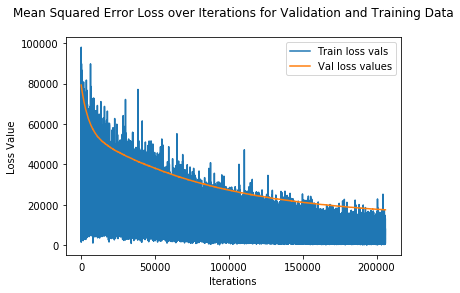

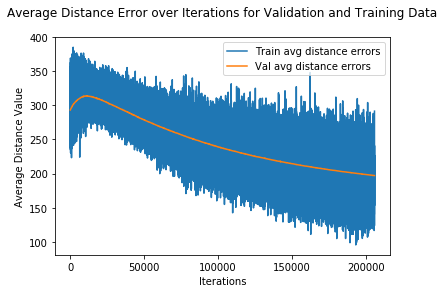

In [42]:
session.run(tf.global_variables_initializer())
#train_handle = session.run(train_itr.string_handle())
#val_handle = session.run(val_itr.string_handle())
print
for i in range(epochs):
    if max_iterations != None and max_iterations <= itr:
        print("here", itr)
        break
    #if i > 0:
    #shuffle and create new batches
    X_train, X_train_ims, Y_train, Y_in_image_train = shuffle(X_train, X_train_ims, Y_train, Y_in_image_train, random_state= i)
    
    
#     X_train_batch = np.array_split(X_train, len(X_train)/batchSize)
#     Y_train_batch = np.array_split(Y_train, len(Y_train)/batchSize)

    
    
    '''
    session.run(train_itr.initializer, feed_dict= feedDictItrTrain)
    j = 0
    while True:
        #print j
        try:
            batch = session.run(next_elementTrain, feed_dict={handle: train_handle})
            #print batch[0].shape
            #print batch[1].shape
        except tf.errors.OutOfRangeError:
              break
    '''
    for j in range(len(np.ceil(X_train/batchSize))-1):
#         if max_iterations != None and max_iterations <= itr:
#             break  
        #print batch[1]
        
                #feedDict = {x: batch[0], y: batch[1], keep_prob: 0.5}
        #feedDict = {x: batch[0], y: batch[1], keep_prob: keepRate}
        if j+batchSize > len(X_train):
            X_train_batch = X_train[j:]
            Y_train_batch = Y_train[j:]
            Y_in_train_batch = Y_in_image_train[j:]
        elif j == len(X_train):
            break
        else:
            X_train_batch = X_train[j:j+batchSize]
            Y_train_batch = Y_train[j:j+batchSize]
            Y_in_train_batch = Y_in_image_train[j:j+batchSize]
        
        
        feedDict = {x: X_train_batch, y: Y_train_batch, y_in_img: Y_in_train_batch}
        trainLoss, trainDist, _ = session.run([mse_loss, totDiff, train_step], feed_dict= feedDict)
        lossArrs[0].append(trainLoss)
        distArrs[0].append(trainDist)
        if trainDist < minDist[0]:
            minDist[0] = trainDist
        if trainLoss < minLoss[0]:
            minLoss[0] = trainLoss
#         if itr%trainAccInterval == 0:
#             trainItrs.append(itr)
#             accArrs[0].append(accuracy.eval(feed_dict= feedDict))
#             if maxAcc[0] < accArrs[0][-1]:
#                 maxAcc[0] = accArrs[0][-1]
        if (itr+1)%valEvalInterval == 0:
            valItrs.append(itr)
            
#             xValBatch, _, yValBatch, _ = train_test_split(X_test, Y_test, test_size= 1-valBatchPercent, shuffle= True)
            feedDictVal = { x: X_test, y: Y_test, y_in_img: Y_in_image_test}
            
            valLoss, valDiff, valPointDiff = session.run([mse_loss, totDiff, pointDiff], feed_dict= feedDictVal)
            distArrs[1].append(valDiff)
            lossArrs[1].append(valLoss)
            if valDiff < minDist[1]:
                minDist[1] = valDiff
                #test accuracy is a new maximum.  Save the graph
                # this saver.save() should be within the same tf.Session() after the training is done
                #Only save if greater than a threshold... that way we don't waste time
#                 if variableValEval:
#                     if minAcc[1] > accLvl:
#                         saver.save(session, save_path)
#                         valEvalInterval = max(1, round(np.sqrt(valEvalInterval)))
#                     elif minAcc[1] < .8*accLvl:
#                         valEvalInterval = max(50, round(np.sqrt(valEvalInterval)))
#                     else:
#                         valEvalInterval = max(5, round(np.sqrt(valEvalInterval)))
#                 else:
#                     saver.save(session, save_path)
            if valLoss < minLoss[1]:
                minLoss[1] = valLoss
            
                # save the weights
                W_star_ = session.run(W_star)
                
        if (itr+1)%logInterval == 0:
            #dataset = dataset.shuffle(buffer_size=10000)
            #feedDict= { x:batch[0], y: batch[1], keep_prob: 1.0}
            
            feedDict= { x: X_train_batch, y: Y_train_batch, y_in_img: Y_in_train_batch}
            trainLoss, trainDiff, trainPtDiff = session.run([mse_loss, totDiff, pointDiff], feed_dict= feedDict)
            if (itr+1)%valEvalInterval != 0:
                #session.run(val_itr.initializer)
                #dVal = session.run(next_elementVal, feed_dict= {handle: val_handle})
                #feedDictVal = { x: dVal[:len(dVal)/2][0], y: dVal[len(dVal)/2:][0], keep_prob: 1.0}
#                 xValBatch, _, yValBatch, _ = train_test_split(xVal, yVal, test_size= 1-valBatchPercent, shuffle= True)
                feedDictVal = { x: X_test, y: Y_test}
                valLoss, valDist, valPointDist = session.run( [mse_loss, totDiff, pointDiff], feedDictVal)
            print("Epoch %d, step %d,     training dist: %g"%(i, j, trainDiff))
            print("                            val dist: %g"%(valDiff))
            print("                      training loss: %g"%(trainLoss))
            print("                     validation loss: %g"%(valLoss))
            print("                  min validation dist: %g"%(minDist[1]))
            print("                       min train dist: %g"%(minDist[0]))
#             plots(lossArrs, distArrs, valItrs, itr+1, save= False)
            print("                                 RT = %.2f"%(time()-sRT))
            sys.stdout.flush()
        itr +=1   
plots(lossArrs, distArrs, valItrs, itr, save= False)




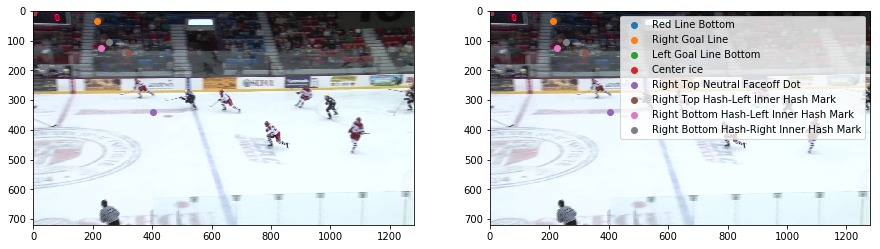

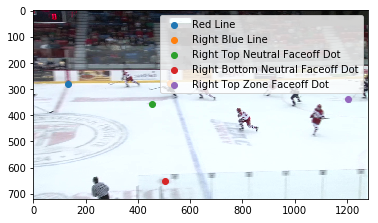

In [55]:
test_preds, testDiff, test_inframe = session.run([predict_op, totDiff, in_im_hat], feed_dict= {x: X_test, y: Y_test, y_in_img: Y_in_image_test})
# print(test_inframe)
def print_n_classifs(n, ims, labels, preds, in_im_pred):
    locs = np.random.choice(range(len(ims)), n, replace= False)
    
    for i in locs:
       
        f = plt.figure(figsize=(15,15))
        #f.subplot(121)
        ax = f.add_subplot(121)
        ax2 = f.add_subplot(122)
        pts = preds[i]
        for feature in key_loc_pairs.keys():
            loc = key_loc_pairs[feature]
#             if (np.array(loc) <= 0).any():
#                 continue
            if in_im_pred[i][loc] == False:
                continue
            x,y = pts[loc]
            if x < 0 or y < 0:
                continue
            ax.scatter(x,y, label= feature)
            ax2.scatter(x,y, label= feature)
        ax.imshow(ims[i])
        ax2.imshow(ims[i])
        ax2.legend()
        plt.show()
        
        
        plt.figure()
        pts = labels[i]
        for feature in key_loc_pairs.keys():
            loc = key_loc_pairs[feature]
            x,y = pts[loc]
            if x > 0 or y > 0:
                plt.scatter(x,y, label= feature)
        plt.imshow(ims[i])
        plt.legend()
        plt.show()
        
n = 1
np.random.seed(42)
print_n_classifs(n, X_test_ims, Y_test, test_preds, test_inframe)


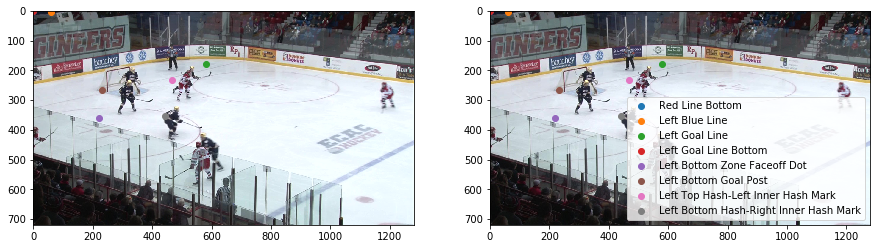

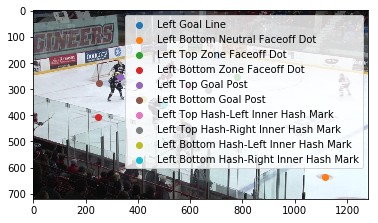

In [57]:
num = 5
train_preds, trainDiff, train_in_im_preds = session.run([predict_op, totDiff, in_im_hat], feed_dict= {x: X_train, y: Y_train})
print_n_classifs(n, X_train_ims, Y_train, train_preds, train_in_im_preds)